In [250]:
# Импорт библиотек для расчета A/B теста
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats


# Для SQL
import pandahouse as ph

Примем гипотезы <br> H0 - новая механика не повлияла на доход или он упал <br> H1 - новая механика позволила увеличить доход

Принимаем уровень значимости alpha = 0.05 <br>
Что подразумевает если уровень значимости (p) который мы расчитаем меньше уровня значимости который мы задали, то с вероятностью 95% можно сказать отвергаем H0 и 5% - вероятность совершить ошибку первого рода согласно ЦПТ. Другими словами чем меньше p-значение, тем больше оснований отклонить нулевую гипотезу.

Основная метрика на которую будем смотреть это доход, прокси метрика это конверсия. Т.к. конверсия может быть выше но товары покупались по более низкой стоимости.

# Задание 1. A/B–тестирование

1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

In [251]:
# Импорт данных
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ni-m/final_project/groups.csv', sep=';') # файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ni-m/final_project/groups_add.csv') # дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ni-m/final_project/active_studs.csv') # файл с информацией о пользователях, которые зашли на платформу в дни проведения
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ni-m/final_project/checks.csv', sep=';') # файл с информацией об оплатах пользователей в дни проведения эксперимента

In [252]:
alpha = 0.05 # задаем уровень значимости

In [253]:
# Проверим данные и узнаем более подробно об их структуре и отсутствующих значениях

In [254]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [255]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [256]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [257]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [258]:
# Проверим группы на соотношение участников тестовой и контрольной
groups.grp.value_counts(normalize=True) * 100

B    80.303152
A    19.696848
Name: grp, dtype: float64

In [259]:
# Проверим группы на соотношение участников тестовой и контрольной
groups_add.grp.value_counts(normalize=True) * 100


B    76.086957
A    23.913043
Name: grp, dtype: float64

Предобработка данных

In [260]:
#Проверим с помощью merge пересечение id в groups и groups_add 
common_ids = pd.merge(groups, groups_add, on='id', how='inner')
common_ids 


,id,grp_x,grp_y


Таблица пустая получается пересечения id нет, необходимо использовать метод pd.cocat для соединения двух таблиц т.к. не сказано что данные не относятся к этому эксперементу или проведены в другой день

In [261]:
all_group = pd.concat([groups, groups_add]) # соединяем груп + груп адс

Далее у нас есть таблица с пользователями которые заходили в день эксперемента на площадку тоесть на которых проводился тест <br> Нам нужно соеденить таблицу с разбивкой по группам с таблицой активных пользователей

In [262]:
# переименуем колонки
checks = checks.rename(columns={'student_id': 'id'})
active_studs = active_studs.rename(columns={'student_id': 'id'})

In [263]:
# мерджим таблицу с группами и таблицу с активными студентами через иннер(берем пересечения в обеих таблицах)
all_group_active = all_group.merge(active_studs, how='right', on='id') # активные студенты разделенные по группам
# Активные студенты которые принесли доход
all_pay = all_group_active.merge(checks, how='inner', on='id')
all_pay.head() # студенты которые были и платили в дни эксперемента

,id,grp,rev
0,1184303,A,1530.0000
1,3354191,B,1900.0001
2,3278734,B,1900.0000
3,720651,A,1980.0000
4,1232221,B,1900.0000


In [264]:
allls = all_group.merge(checks, how='inner', on='id') # всего студентов от которых были совершены платежы в дни эксперемента
allls

,id,grp,rev
0,1627,A,990.0
1,3185,B,690.0
2,25973,B,690.0
3,26280,B,690.0
4,100300,B,990.0
...,...,...,...
536,5645737,B,1900.0
537,5651566,B,1900.0
538,5662322,B,1900.0
539,5681918,B,1900.0


In [265]:
not_use = pd.concat([all_pay, allls]).drop_duplicates(keep=False) # пользователи которые не были на сайте в день эксперемента
not_use.id.count() # пользователи которые небыли на сайте в день эксперемента

149

In [266]:
not_use.head()

,id,grp,rev
1,3185,B,690.0
2,25973,B,690.0
3,26280,B,690.0
5,100645,B,630.0
6,102534,B,580.0


Оценка групп пользователей которых небыло на сайте в дни эксперемента

In [267]:
not_use.grp.value_counts(normalize=True)*100 # соотношение группы 

B    80.536913
A    19.463087
Name: grp, dtype: float64

In [268]:
not_use.rev.sum() # доход пользователей 

105532.0001

In [269]:
not_use.rev.value_counts()  # данные по количеству платежей 

690.0000     61
290.0000     24
990.0000     19
199.0000     14
1140.0000    14
1900.0000     4
580.0000      4
840.0000      3
398.0000      2
1900.0001     1
1180.0000     1
1980.0000     1
630.0000      1
Name: rev, dtype: int64

In [270]:
not_use.rev.mean() # средний чек пользователей которых небыло в день эксперемента

708.2684570469798

Предпологаю это автоматическая оплата подписки, и т.к. у нас задача проверить реакцию пользователей на новую систему оплаты эти данные во внимание не берем

Далее работаем с датафреймом all_pay

# Расчеты

Мы можем посмотрет на наши данные сначала на графиках <br> и предположить об их нормальности для последуйщего выбора метода для анализа, но все равно нужно проверить через тест

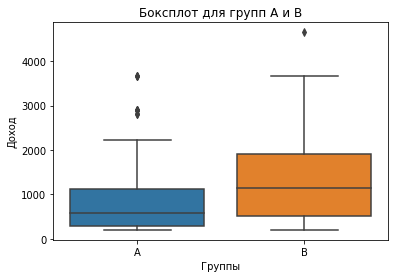

In [271]:
# Построение боксплот
sns.boxplot(data=all_pay, x="grp", y="rev") 

# Добавляем название графика
plt.title('Боксплот для групп A и B')

# Добавляем название осей
plt.xlabel('Группы')
plt.ylabel('Доход')

plt.show()

Судя по графику видимо что медиана у контрольной группы (группа А) и тестовой группы (B) различаются,<br>
но данных в группе B больше, так же нижний квартиль у тестовой группы и верхний больше чем у контрольной группы, <br> точки отображают выбрасы в каждом графике. 
Усы в каких границах данные находятся.
По данному графику сложно сказать есть ли статистические различия т.к. данных в группе B больше. Если бы нижняя граница ящика была выше верхней тогда можно было бы более точно сказать что есть различия.

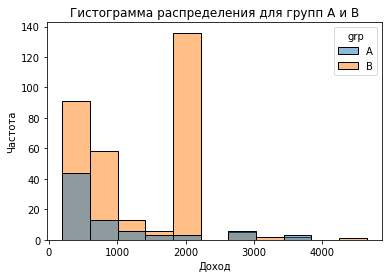

In [272]:
# Строим гистограмму распределения дохода
sns.histplot(data=all_pay, x="rev", hue="grp")

# Добавляем название графика
plt.title('Гистограмма распределения для групп A и B')

# Добавляем название осей
plt.xlabel('Доход')
plt.ylabel('Частота')

# Показываем график
plt.show()

По данному графику явно видно что распределение не нормальное, много данных находится у группы B с доходом около 2000.
Ну опять же по данному графику сказать что то однозначно сложно.
Но мы понимаем что данные распределены не нормально.

In [273]:
print('Доход в контрольной группе', all_pay.query('grp=="A"').rev.sum())
print('Доход в тестовой группе', all_pay.query('grp=="B"').rev.sum())

Доход в контрольной группе 72820.0
Доход в тестовой группе 394974.0035


In [274]:
# Запишем данные контрольной и тестовой группы в переменные

kontrol = all_pay.query('grp=="A"').rev # контрольная группа
test = all_pay.query('grp=="B"').rev # тестовая группа

Проверка распределения среднего для дохода в контрольной и тестовой группе

In [275]:
sample_means_control = [] # сюда записывается симуляция контрольной группы
sample_means_target = [] # сюда записывается симуляция тестовой группы

for i in range(10000):     #симулируем выборку
  sample_control = kontrol.sample(frac=1, replace=True) #симулируем выборку
  sample_target = test.sample(frac=1, replace=True) #симулируем выборку
  sample_means_control.append(sample_control.mean()) # добавляем в созданые переменные
  sample_means_target.append(sample_target.mean()) # добавляем в созданые переменные
  


# check for normality by Shapiro-Wilk test #

sp = shapiro(sample_means_control) # проводим тест Шапиро для того чтобы понять нормально ли распределение среднего значения в контрольной группе
concl = '=> Не нормальное' if sp[1]>0.05 else '=> Нормальное' 
print('Тест на нормальность распределения control группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

sp = shapiro(sample_means_target)# проводим тест Шапиро для того чтобы понять нормально ли распределение среднего значения в тестовой группе
concl = '=> Не нормальное' if sp[1]>0.05 else '=> Нормальное' 
print('Тест на нормальность распределения test группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

Тест на нормальность распределения control группы: W = 0.997 , p-value = 0.000 => Нормальное
Тест на нормальность распределения test группы: W = 1.000 , p-value = 0.956 => Не нормальное


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Группы имеют разное распределение среднего: контрольная группа не нормальное распределение среднего а тестовая нормальное распределение среднего, поэтому невозможно применить ттест поэтому необходимо использовать бустрап.

При использовании бустрап сравним доверительные интервалы, тем самым если доверительные интервалы не пересекаются и не перекрывают ноль, значит группы имеют статистически значимое различие

In [276]:
# Бустрап симуляция для контрольной группы
#сюда мы будем складывать результаты
medians_kon = []

#повторяем процесс 10000 раз
for i in range(10000):
    #симулируем выборку
    sample_data = kontrol.sample(frac=1, replace=True)

    #считаем показатель - в данном случае медиану
    sample_median = sample_data.median()

    #добавляем результат в список
    medians_kon.append(sample_median)

In [277]:
# Бустрап симуляция для тестовой группы
#сюда мы будем складывать результаты
medians_test = []

#повторяем процесс 10000 раз
for i in range(10000):
    #симулируем выборку
    sample_data = test.sample(frac=1, replace=True)

    #считаем показатель - в данном случае медиану
    sample_median = sample_data.median()

    #добавляем результат в список
    medians_test.append(sample_median)

Определяем 95% доверительный интервал для этого определим квантили контрольной и тестовой группы 

In [278]:
print(pd.Series(medians_kon).quantile(0.025)) # квантили контрольной группы
print(pd.Series(medians_kon).quantile(0.975))

397.7875000000002
765.0


In [279]:
print(pd.Series(medians_test).quantile(0.025)) # # квантили тестовой группы 
print(pd.Series(medians_test).quantile(0.975))

990.0
1900.0


Мы можем утверждать с 95% вероятностью что группы по доходу, имеют статистические различия, т.к. интервалы не пересекаются.<br>
Получается медианна дохода в контрольной и тестовой имею стат. значимое различие

Сделаем ещё один бустрап для опеределения 95% доверительного интервала разниц медиан двух групп

In [280]:
#бустреп для разницы медиан
median_diff = []

for i in range(10000):
    sample_data_control = kontrol.sample(frac=1, replace=True)
    sample_median_control = sample_data_control.median()
    
    
    sample_data_exp = test.sample(frac=1, replace=True)
    sample_median_exp = sample_data_exp.median()
    
    sample_median_diff = sample_median_exp - sample_median_control
    median_diff.append(sample_median_diff)
    

In [281]:
pd.Series(median_diff).quantile(0.025)

349.8750000000001

In [282]:
pd.Series(median_diff).quantile(0.975)

1320.0

Получается что разница между медианами дохода каждой группы положительная и она статистически значимая, и лежит в пределах от 300 до 1320

Расчитаем CR и ARPU, ARPPU и проверим их на стат. значимое различие

In [283]:
cr_kon = all_pay.grp.value_counts().A / all_group_active.grp.value_counts().A * 100
# конверсия в контрольной группе
print("Конверсия в контрольной группе:", cr_kon.round(2))

# конверсия в тестовой группе
cr_test = all_pay.grp.value_counts().B / all_group_active.grp.value_counts().B * 100
print("Конверсия в тестовой группе:", cr_test.round(2))

# Разница между контрольной и тестовой группой
dif = cr_kon - cr_test
print("Разница между контрольной и тестовой группой всех студентов:", dif.round(2))

Конверсия в контрольной группе: 5.07
Конверсия в тестовой группе: 4.62
Разница между контрольной и тестовой группой всех студентов: 0.46


<span style="color:red;">Принимаем уровень значимости alpha = 0.05 </span> <br>
H0 - между группами нет стат. значимых различий <br>
H1 - между группами есть стат. значимые различия

In [284]:
studs_for_hi = active_studs.merge(all_group, on='id', how='inner') # соединяем датафреым
itog = studs_for_hi.merge(checks, on='id', how='left') # соединяем с оплатами
itog.fillna('0', inplace=True) # Убираем NaN на нули
itog.rev = pd.to_numeric(itog.rev) # переводим rev колонку в числа
itog['bbb'] = itog.rev != 0 # создаем колонку для вычесления тех кто платил

In [285]:
scipy.stats.chi2_contingency(pd.crosstab(itog.grp,itog.bbb)) # считаем хи квадрат

(0.48480826522557896,
 0.48625240457231045,
 1,
 array([[1465.71897854,   72.28102146],
        [6483.28102146,  319.71897854]]))

Значение pvalue превышает заданый нами, получается распределения не имеют стат значимых различий!

Расчитаем ARPU для контрольной и тестовой групп

In [286]:
ARPU = all_pay.query('grp=="A"').rev.sum() / all_group_active.query('grp=="A"').id.nunique()
print("ARPU контрольной группы:", ARPU.round(2))
ARPU = all_pay.query('grp=="B"').rev.sum() / all_group_active.query('grp=="B"').id.nunique()
print("ARPU тестовой группы:", ARPU.round(2))

ARPU контрольной группы: 47.35
ARPU тестовой группы: 58.06


Сравним ARPU у контрольной и тестовой группы <br>
<span style="color:red;">Принимаем уровень значимости alpha = 0.05 </span> <br>
H0 - нет статистически значимой разницы в доходах на одного пользователя между контрольной и тестовой группой<br>
H1 - есть статистически значимая разница в доходах на одного пользователя между контрольной и тестовой группой

In [287]:
akk = all_group_active.merge(all_pay, on='id', how='left') # создаем датафрейм для расчета ARPU
akk.fillna('0', inplace=True) # Замена NaN на 0
akk.rev = pd.to_numeric(akk.rev) # Изменение типа колонки на числовой формат

Проверим выборки на нормальность распределения среднего

In [288]:
sample_means_control = [] # сюда записывается симуляция контрольной группы
sample_means_target = [] # сюда записывается симуляция тестовой группы

for i in range(10000):     #симулируем выборку
  sample_control = akk.query('grp_x=="A"').rev.sample(frac=1, replace=True) #симулируем выборку
  sample_target = akk.query('grp_x=="B"').rev.sample(frac=1, replace=True) #симулируем выборку
  sample_means_control.append(sample_control.mean()) # добавляем в созданые переменные
  sample_means_target.append(sample_target.mean()) # добавляем в созданые переменные
  


# check for normality by Shapiro-Wilk test #

sp = shapiro(sample_means_control) # проводим тест Шапиро для того чтобы понять нормально ли распределение среднего значения в контрольной группе
concl = '=> Не нормальное' if sp[1]>0.05 else '=> Нормальное' 
print('Тест на нормальность распределения control группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

sp = shapiro(sample_means_target)# проводим тест Шапиро для того чтобы понять нормально ли распределение среднего значения в тестовой группе
concl = '=>  Не нормальное' if sp[1]>0.05 else '=> Нормальное' 
print('Тест на нормальность распределения test группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

Тест на нормальность распределения control группы: W = 0.998 , p-value = 0.000 => Нормальное
Тест на нормальность распределения test группы: W = 1.000 , p-value = 0.014 => Нормальное


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Распределение среднего  нормальное поэтому возьмем т-тест

In [289]:
ttest_ind(akk.query('grp_x=="A"').rev, akk.query('grp_x=="B"').rev) # Т тест для независимых выборок

Ttest_indResult(statistic=-1.225341107379344, pvalue=0.22048133326988403)

Знак минус перед t-статистикой указывает на то, в какую сторону смещено среднее значение первой группы относительно второй. В данном случае, отрицательное значение говорит о том, что среднее значение первой группы меньше среднего значения второй группы.
p-значение больше уровня значимости (обычно 0.05), то нет статистически значимых различий, и мы не можем отвергнуть нулевую гипотезу. В данном случае p-значение довольно высокое (больше 0.05), поэтому нет достаточных оснований отвергнуть нулевую гипотезу.

Но на всякий случай перепроверим бустрапом, т.к. выборки небольшие и можно его использовать это не займет много времени

In [290]:
scipy.stats.bootstrap((akk.query('grp_x=="A"').rev, ), np.mean) # бустрап контрольной группы 

BootstrapResult(confidence_interval=ConfidenceInterval(low=34.57819681392756, high=63.84604871368595), standard_error=7.399760245607616)

In [291]:
scipy.stats.bootstrap((akk.query('grp_x=="B"').rev, ), np.mean) # бустрап тестовой группы

BootstrapResult(confidence_interval=ConfidenceInterval(low=51.10018316573677, high=65.9136870503895), standard_error=3.7566645050320693)

Контрольная и тестовая группы пересекаются значит принимаем H0, нет статистически значимой разницы в доходах на одного пользователя между контрольной и тестовой группой

Расчитаем ARPPU

In [292]:
ARPPU = all_pay.query('grp=="A"').rev.sum() / all_pay.query('grp=="A"').id.nunique()
print("ARPPU контрольной группы:", ARPPU.round(2))
ARPPU = all_pay.query('grp=="B"').rev.sum() / all_pay.query('grp=="B"').id.nunique()
print("ARPPU тестовой группы:", ARPPU.round(2))    

ARPPU контрольной группы: 933.59
ARPPU тестовой группы: 1257.88


Сравним ARPU у контрольной и тестовой группы <br>
<span style="color:red;">Принимаем уровень значимости alpha = 0.05 </span> <br>
H0 - нет статистически значимой разницы в доходах на одного пользователя между контрольной и тестовой группой<br>
H1 - есть статистически значимая разница в доходах на одного пользователя между контрольной и тестовой группой

Проверим выборки на нормальность распределения среднего

In [293]:
sample_means_control = [] # сюда записывается симуляция контрольной группы
sample_means_target = [] # сюда записывается симуляция тестовой группы

for i in range(10000):     #симулируем выборку
  sample_control = all_pay.query('grp=="A"').rev.sample(frac=1, replace=True) #симулируем выборку
  sample_target = all_pay.query('grp=="B"').rev.sample(frac=1, replace=True) #симулируем выборку
  sample_means_control.append(sample_control.mean()) # добавляем в созданые переменные
  sample_means_target.append(sample_target.mean()) # добавляем в созданые переменные
  


# check for normality by Shapiro-Wilk test #

sp = shapiro(sample_means_control) # проводим тест Шапиро для того чтобы понять нормально ли распределение среднего значения в контрольной группе
concl = '=> Не нормальное' if sp[1]>0.05 else '=> Нормальное' 
print('Тест на нормальность распределения control группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

sp = shapiro(sample_means_target)# проводим тест Шапиро для того чтобы понять нормально ли распределение среднего значения в тестовой группе
concl = '=>  Не нормальное' if sp[1]>0.05 else '=> Нормальное' 
print('Тест на нормальность распределения test группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

Тест на нормальность распределения control группы: W = 0.998 , p-value = 0.000 => Нормальное
Тест на нормальность распределения test группы: W = 1.000 , p-value = 0.321 =>  Не нормальное


In [294]:
scipy.stats.bootstrap((all_pay.query('grp=="A"').rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=752.8081150697996, high=1167.3284288006312), standard_error=103.84959210411917)

In [295]:
scipy.stats.bootstrap((all_pay.query('grp=="B"').rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1171.9147997467198, high=1346.8192779739127), standard_error=44.84051857314195)

Интервалы не пересекаются значит можно сделать вывод что средний доход от одного платящего пользователя между контрольной и тестовой группой имеют различия

# ВЫВОД

Можно сделать новую модель оплаты. Повысит доход.

Конверсия:
-----------
Показатели конверсии статистически значимо не отличаются между контрольной и тестовой группами. Это означает, что новая механика не оказала значительного влияния на привлечение пользователей к определенным действиям.

Доход на одного пользователя:
-----------
Статистические данные указывают на то, что доход на одного пользователя статистически значимо не различается между контрольной и тестовой группами.

Доход на одного платящего пользователя:
-----------
Важное наблюдение заключается в том, что доход на одного платящего пользователя статистически значимо различается между группами. Это может указывать на потенциальные изменения в поведении пользователей, которые производят платежи.
Доход по группам:
-----------
Статистические данные указывают на то, что медиана дохода в контрольной и тестовой группе имеют различия, что в свою очередь указывает на стат. значимые различия по доходу в группах при симуляции выборок через бустрап.

Дополнительные проверки:
-----------
Отмечено необходимость проведения дополнительных проверок, включая анализ наличия оплат подписок в дни эксперимента, а также исследование характеристик 149 пользователей, которые могут вносить перекосы в данные.

Предложение провести еще один A/B тест:
-----------
Рекомендуется провести еще один A/B тест с целью исключить возможные перекосы и собрать более корректные данные перед реализацией новой модели оплаты. 

# Задание 2. SQL


2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. <br>
Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.<br> 
NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.



Создаем соединение с SQL 

In [296]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default.peas',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

В данном запросе не учитывается месяц так как данные и так за 2 дня этого месяца.

In [297]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
    COUNT(DISTINCT st_id) AS hard_student
FROM (
SELECT 
    st_id
FROM 
    default.peas
GROUP BY
    st_id
HAVING 
    SUM(correct) >= 20
    )
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,hard_student
0,136


In [298]:
connection_default_2 = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':['default.peas', 'default.studs', 'default.final_project_check'],
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [299]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
SELECT 
    B.test_grp AS groups, -- указание тестовой и контрольной группы
    round(SUM(C.money_1) / COUNT(DISTINCT B.st_id), 2) AS ARPU, -- доход на одного пользователя
    round(sumIf(C.money_1, A.cor > 10) / uniqExactIf(B.st_id, A.cor > 10), 2) AS ARPAU, -- доход на одного активного пользователя
    round(countIf(C.st_id, C.money_1 > 0) / COUNT(DISTINCT B.st_id) * 100, 2) AS cr, -- конверсия пользователя
    round(uniqExactIf(C.st_id, A.cor > 10 AND C.money_1 > 0) / uniqExactIf(B.st_id, A.cor > 10) * 100, 2) AS cr_activ, -- конверсия активных пользователей
    round(uniqExactIf(A.st_id, A.math>=2 AND C.math > 0) / uniqExactIf(A.st_id, A.math>= 2) * 100, 2) AS cr_activ_math_byu -- конверсия активных по математике
FROM
    (
    SELECT
        st_id,
        SUM(correct) AS cor,
        sumIf(correct, subject = 'Math') as math
    FROM
        default.peas
    GROUP BY
        st_id
    ) AS A
    
--соединяем таблицу с группами

RIGHT JOIN
    default.studs AS B ON A.st_id = B.st_id
    
-- соединяем таблицу с деньгами, сгруппированную по ст ид
LEFT JOIN 
    (
    SELECT
        st_id,
        SUM(money) AS money_1,
        sumIf(money, subject = 'Math') AS math
    FROM
        default.final_project_check
    GROUP BY
        st_id
    ) AS C ON B.st_id = C.st_id
GROUP BY
    B.test_grp
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default_2)
q_test

,groups,ARPU,ARPAU,cr,cr_activ,cr_activ_math_byu
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


# Задание 3. Python


3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [300]:
path_to_file = ('groups_add.csv') # задается аргумент для функции с названием файла

In [301]:
import pandas as pd

def calculate(path_to_file):
    
    try:
        # Импорт данных
        groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ni-m/final_project/groups.csv', sep=';') # файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
        groups_add = pd.read_csv(path_to_file) # дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
        active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ni-m/final_project/active_studs.csv') # файл с информацией о пользователях, которые зашли на платформу в дни проведения
        checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ni-m/final_project/checks.csv', sep=';') # файл с информацией об оплатах пользователей в дни проведения эксперимента
        #переименуем колонки
        checks = checks.rename(columns={'student_id': 'id'})
        active_studs = active_studs.rename(columns={'student_id': 'id'})

        all_group = pd.concat([groups, groups_add]) # соединяем груп + груп адс
        # мерджим таблицу с группами и таблицу с активными студентами через иннер(берем пересечения в обеих таблицах)
        all_group_active = all_group.merge(active_studs, how='right', on='id') # активные студенты разделенные по группам
        # Активные студенты которые принесли доход
        all_pay = all_group_active.merge(checks, how='inner', on='id')
        
        # расчеты метрик конверсия, ARPU, ARPPU, доход
        rev_kon = all_pay.query('grp=="A"').rev.sum() # контрольная группа
        rev_test = all_pay.query('grp=="B"').rev.sum() # тестовая группа
        cr_kon = all_pay.grp.value_counts().A / all_group_active.grp.value_counts().A * 100
        cr_test = all_pay.grp.value_counts().B / all_group_active.grp.value_counts().B * 100
        ARPU_con = all_pay.query('grp=="A"').rev.sum() / all_group_active.query('grp=="A"').id.nunique()
        ARPU_test = all_pay.query('grp=="B"').rev.sum() / all_group_active.query('grp=="B"').id.nunique()
        ARPPU_con = all_pay.query('grp=="A"').rev.sum() / all_pay.query('grp=="A"').id.nunique()
        ARPPU_test = all_pay.query('grp=="B"').rev.sum() / all_pay.query('grp=="B"').id.nunique()
        # создадим датафрейм для отображения метрик
        data = pd.DataFrame({'Group': ['A', 'B'], 'Conversion': [cr_kon, cr_test], 'ARPU': [ARPU_con, ARPU_test], 'ARPPU': [ARPPU_con, ARPPU_test], 'Revenue': [rev_kon, rev_test]})
        data.to_csv('data.csv', index=False)
        return data
    except Exception as e: # если функция не сработает вывести тип ошибки
        print("Error", f"An error occurred: {str(e)}")

In [302]:
calculate(path_to_file) # результат запуска

,Group,Conversion,ARPU,ARPPU,Revenue
0,A,5.071521,47.347204,933.589744,72820.0000
1,B,4.615611,58.058798,1257.878992,394974.0035


### Функция для визулизации

In [303]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def visual():
    data = pd.read_csv('data.csv')

    # Создаем отдельные графики для каждой метрики
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Сравнение показателей: контрольная группа (A) и тестовая группа (B)')

    # График для конверсии
    sns.barplot(x='Group', y='Conversion', data=data, ax=axes[0, 0], ci=None, palette='pastel')
    axes[0, 0].set_title('Conversion')

    # График для ARPU
    sns.barplot(x='Group', y='ARPU', data=data, ax=axes[0, 1], ci=None, palette='pastel')
    axes[0, 1].set_title('ARPU')

    # График для ARPPU
    sns.barplot(x='Group', y='ARPPU', data=data, ax=axes[1, 0], ci=None, palette='pastel')
    axes[1, 0].set_title('ARPPU')
    
    # График для дохода
    sns.barplot(x='Group', y='Revenue', data=data, ax=axes[1, 1], ci=None, palette='pastel')
    axes[1, 1].set_title('Revenue')

    plt.show()

In [ ]:
# Пример вызова функции
visual()